# GPU FIT

Import

In [82]:
# import packages

import sys
sys.path.insert(1,r'C:\Users\q130jm\iCloudDrive\Documents\PhD\Coding\Python\GPU_fit')
import SMLM
import importlib
importlib.reload(SMLM)
from SMLM import *
import pims
from glob import glob
biplane = False

In [2]:
# import images

#pth="./synthetic testdata/"

#pth = r'\\ces-1.i-med.ac.at\imed\Biomedizinische_Physik\groups\SMLM\STORM stacks\Nanorulers_80nm\Stack_2023_08_23\take_1_45_220mw_25ms'
#name = 'take_1_45_220mw_25ms'
#filename = sorted(glob(f"{pth}\\take_1_45_220mw_25ms.tif"))


pth = r'\\ces-1.i-med.ac.at\imed\Biomedizinische_Physik\groups\SMLM\synthetic data Julia'
name = 'take_1_45_220mw_25ms'
filename = sorted(glob(f"{pth}\\data.tif"))

vid = [pims.open(n) for n in filename]
stack = np.array(vid[0])

if biplane: 
    filename2 = sorted(glob(pth + "spiral_8fold_dz=10nm_R=100nm_s5000_bg20.tif")) #for biplane imaging
    vid2 = [pims.open(n) for n in filename2]
    stack = np.concatenate((stack, np.array(vid2[0])), axis = 2)

#imshow(stack[0,:,:])

In [200]:
# import aberrations

import mat73 as mat
path = r'\\ces-1.i-med.ac.at\imed\Biomedizinische_Physik\groups\SMLM\STORM stacks\Nanorulers_80nm\Stack_2023_08_23'
name = 'aberr_cyl'
file_name = '\\' + name + '.mat'
file_to_load = path + file_name
prl = mat.loadmat(file_to_load)
aberr_index = prl['aberr']['Z_modes']
aberr_value = prl['aberr']['Z_magn']
apodization = prl['aberr']['T_coefs']
del mat, file_to_load

Initialize camera and objective

In [136]:
# cam and obj
cam = Camera(pixsize = 6500, # nm
             QE = 0.75, 
             baseline = 100, 
             gain = 0.21, 
             EM_gain = 1, 
             readnoise = 1)

obj = Objective(M = 60, 
                NA = 1.49, 
                RI = 1.52)

Preloc

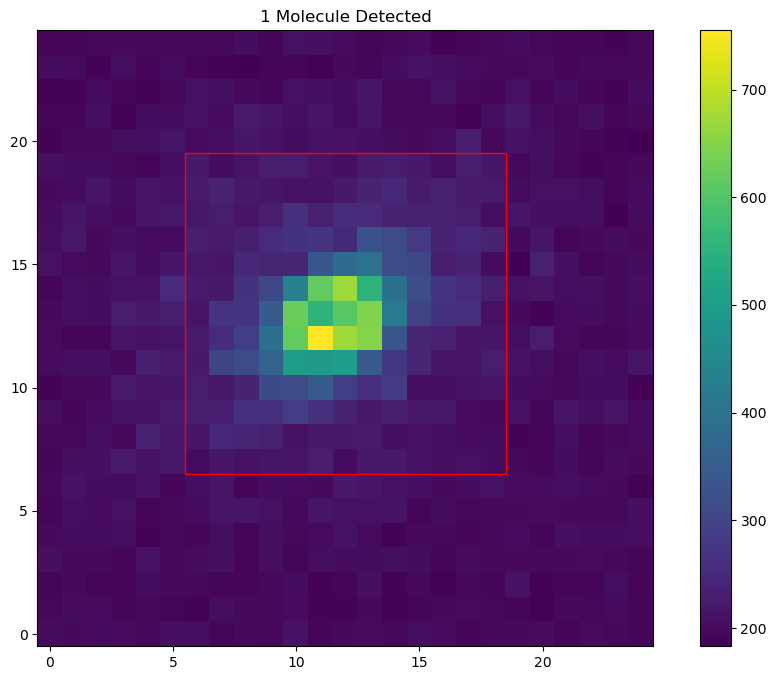

In [5]:
image = stack[100,...]
sigma = 1           # sigma...sigma for Gaussian filter to smooth the raw images
min_dist = 7        # min_dist...minimum distance between molecules in pixels
thresh = 2          # thresh...threshold for peak detection: a molecule image rejected if max(image) < thresh * min(image)
N_crop=13           # pixel size of the cropped image
preloc_setup(image, sigma=sigma, min_dist=min_dist, thresh=thresh, N_crop=N_crop)

In [6]:
preloc_table, I_crop = preloc_and_crop(stack, sigma=sigma, min_dist=min_dist, thresh=thresh, N_crop = h.xr.shape[0]//h.os)
I_photons = prepare_images_for_fitting(I_crop, cam) #convert camera images from counts to photons

--- Preloc started ---
Frames: 1000
Analized:
	 10 %
	 20 %
	 30 %
	 40 %
	 50 %
	 60 %
	 70 %
	 80 %
	 90 %
	 100 %
--- Preloc completed ---
Molecules found:  572


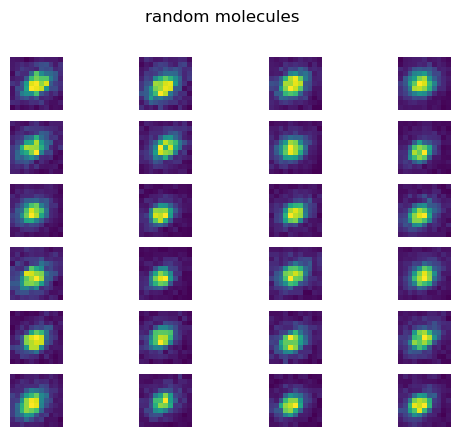

In [7]:
show_prelocs(I_photons, n=24)

Initialize PSF

In [137]:
index = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 37]
aberr = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# psf
h = psf(z_min = 0,
        z_max = 500,
        z_defocus = 400,
        Nk = 128,
        Nx = 15, 
        ux = cam.pixsize/obj.M,
        uz = 5,
        Z_modes = index,
        Z_magn = aberr,
        os=2,
        SA_correction = False)
print('Aberrations magnitude:', round(h.aberr_magn/2/np.pi,3), 'rad')
#h.show_psf_xy()  # plot the psf xy section
#h.show_psf_z()   # plot the psf z section
#h.show_pupil()   # plot the pupil phase and apodization
#h.show_CRLB(cam)

Aberrations magnitude: 0.0 rad


In [140]:
h.ux

1.0833333333333334e-07

Precise loc

In [135]:
import importlib
import SMLM ; importlib.reload(SMLM)
from SMLM import *

In [78]:
results, fit_results = perform_fit(I_photons, preloc_table, h, batch_size = 1000)

--- Precise loc started ---
Fitting batch :  1 / 1
--- Precise loc completed ---


In [134]:
results = add_CRLB(h, cam, results)
results

--- Single CRLB started ---
Localizations: 572
Computed:
	 10 %
	 20 %
	 30 %
	 40 %
	 50 %
	 60 %
	 70 %
	 80 %
	 90 %
	 100 %
--- Single CRLB completed ---


,id,x,y,z,signal,bg,LLR,crlb x,crlb y,crlb z
0,1,1354.581963,1213.906696,91.816376,4699.962891,26.803307,137.928406,2.55,2.55,3.73
1,2,1224.107236,1198.708152,497.901520,3576.806641,35.016697,221.571350,4.84,4.84,11.40
2,3,1221.590277,1359.842542,39.944450,4544.750977,27.898552,165.510910,3.91,3.91,3.48
3,4,1223.960975,1209.176845,496.331329,3640.037842,34.992695,248.530548,4.64,4.64,11.28
4,5,1281.459774,1184.988119,491.350037,6083.647949,26.582451,180.156616,2.37,2.37,5.92
...,...,...,...,...,...,...,...,...,...,...
567,568,1236.281604,1331.916447,51.680756,8415.553711,31.722486,402.461029,2.07,2.07,2.02
568,569,1242.214710,1205.712238,495.443939,3553.408203,34.546062,226.956757,4.72,4.72,11.49
569,570,1283.202732,1381.620191,496.596680,4788.304688,31.216745,168.089355,3.34,3.34,8.12
570,571,1177.522935,1276.637612,41.254574,4347.250488,28.110546,163.336639,4.10,4.10,3.65


x =  1291.6  ( 61.4 ) nm
y =  1281.5  ( 63.6 ) nm
z =  459.7  ( 44.1 ) nm
NP =  8195.0  ( 4190.0 ) photons
BG =  27.0  ( 2.9 ) photons
LLR =  264.6  ( 120.1 )


<Figure size 640x480 with 0 Axes>

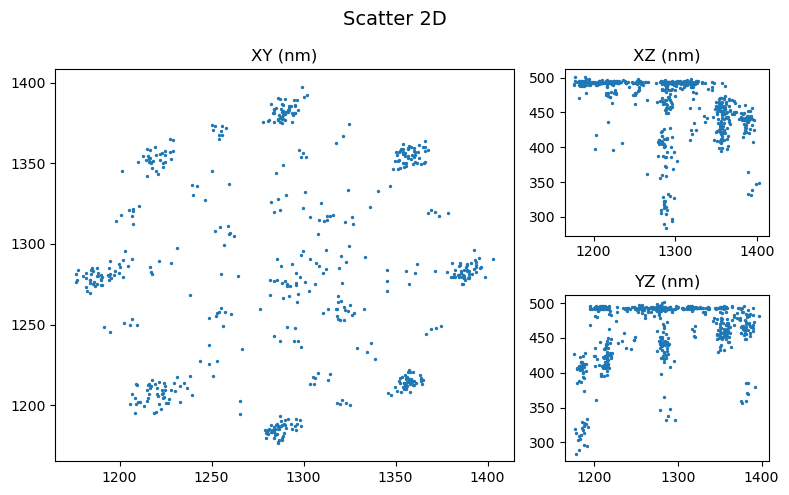

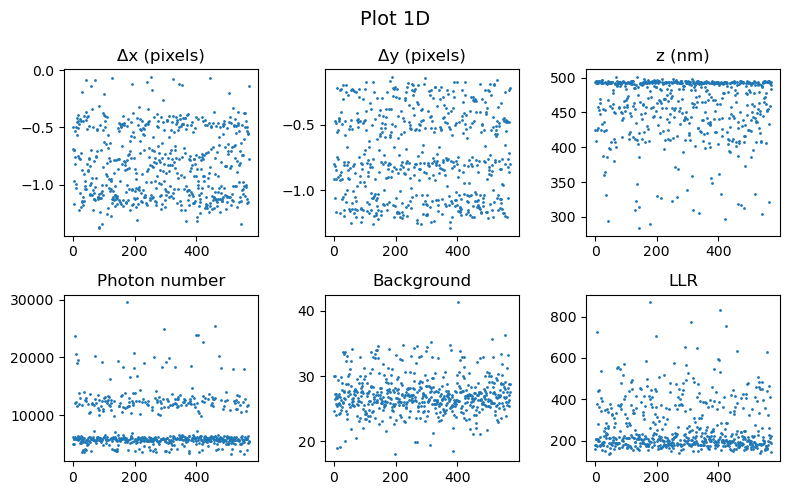

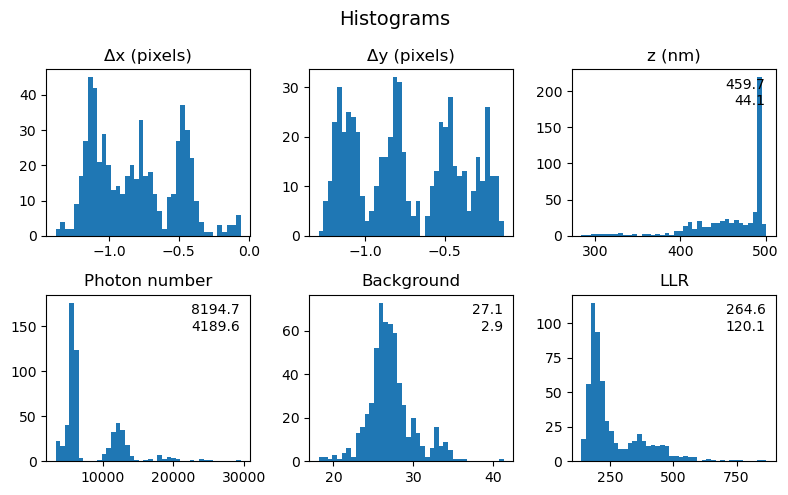

In [17]:
#FILTERING & VISUALIZATION
pxl = np.inf
filtered_results, filtered_fit_results = filt_results(results, fit_results,
            x_min = -pxl, x_max = pxl,
            y_min = -pxl, y_max = pxl,
            z_min = -np.inf, z_max = np.inf,
            signal_min = -100, signal_max = 40000,
            LLR_max = np.inf)

show_results(results, fit_results,
             print_results = True,
             plot_3d = True,
             plot_2d = True,
             plot_1d = True, ms = 2,#0.2, 
             plot_hist = True, bins = 40)

Save Data

In [ ]:
name = 'take_1_45_220mw_25ms'
file_to_save = pth + '\\fitgpu_' + name + '.csv'

results.to_csv(file_to_save, index=False)
